### **Introduction to the Dataset and Goal of my Analysis**  

The **Telco Customer Churn** dataset, provided by IBM, contains detailed information about telecom customers, including their service subscriptions, account details, and demographics. Each row represents an individual customer, with a key column, **Churn**, indicating whether they have left the service within the last month. The dataset includes various attributes such as the type of internet service, contract duration, payment methods, and additional services like online security, device protection, and streaming options.  

This analysis focused on understanding the factors that contribute to customer churn. By examining trends in service usage, contract types, and payment preferences, meaningful patterns were identified. These insights helped in recognizing high-risk customers and developing strategies to improve retention by addressing the key reasons behind churn.

In [1]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import scipy.stats as stats
import seaborn.axisgrid as axisgrid
from scipy.stats import f_oneway, ttest_ind

#### In my analysis, I imported several libraries to efficiently handle data, perform computations, and create meaningful visualizations. Pandas was used for data manipulation and analysis, allowing easy handling of tabular data. NumPy was essential for numerical operations, especially when working with arrays and mathematical computations. To visualize trends and patterns in the dataset, I used Matplotlib and Seaborn, which provided clear and insightful graphs. Additionally, Plotly was incorporated to create interactive visualizations for better data exploration. If applicable, I also used Scikit-learn (Sklearn) for preprocessing tasks and implementing machine learning models. Each of these libraries played a crucial role in making the analysis more structured, insightful, and visually interpretable. ####

In [2]:
# Load the dataset
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")  # Ensure correct file path

# Inspect dataset structure
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [3]:
# Handling missing values
print("Missing Values BEFORE Conversion:\n", df.isnull().sum())

# Convert 'TotalCharges' to numeric, replacing blank spaces with NaN
df['TotalCharges'] = df['TotalCharges'].str.strip().replace("", np.nan).astype(float)
print("Missing Values AFTER Conversion (Before Filling):\n", df.isnull().sum())

# Fill missing values with the median
df.fillna({'TotalCharges': df['TotalCharges'].median()}, inplace=True)

# Check missing values after filling
print("Missing Values AFTER Filling:\n", df.isnull().sum())

Missing Values BEFORE Conversion:
 customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64
Missing Values AFTER Conversion (Before Filling):
 customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
To

In [4]:
# Remove infinite values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
# Remove duplicates
print(f"Number of duplicate rows: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)

Number of duplicate rows: 0


In [5]:
# Detect and treat outliers using IQR
numeric_cols = df.select_dtypes(include=[np.number]).columns
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_removed = ((df[numeric_cols] < lower_bound) | (df[numeric_cols] > upper_bound)).any(axis=1).sum()
df = df[~((df[numeric_cols] < lower_bound) | (df[numeric_cols] > upper_bound)).any(axis=1)]
print(f"Number of outliers removed: {outliers_removed}")

Number of outliers removed: 1142


In [6]:
# Standardize categorical values
cat_cols = df.select_dtypes(include=['object']).columns

# Convert text to lowercase and strip whitespace
df[cat_cols] = df[cat_cols].apply(lambda x: x.str.lower().str.strip())

# Check for unexpected categorical values
for col in cat_cols:
    print(f"{col}: {df[col].unique()}")

# Replace 'no internet service' and 'no phone service' with 'no'
no_service_cols = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df[no_service_cols] = df[no_service_cols].replace('no internet service', 'no')
df['MultipleLines'] = df['MultipleLines'].replace('no phone service', 'no')

# Fix common typos and inconsistencies
df.replace({
    "PaymentMethod": {
        "credit card (automatic)": "credit card",
        "bank transfer (automatic)": "bank transfer"
    },
    "Contract": {
        "month-to-month": "monthly"
    }
}, inplace=True)

# Convert Yes/No columns to binary values
binary_cols = ['Churn', 'PaperlessBilling', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df[binary_cols] = df[binary_cols].apply(lambda x: x.map({"yes": 1, "no": 0}))

# Check for unexpected categorical values
for col in cat_cols:
    print(f"{col}: {df[col].unique()}")

customerID: ['7590-vhveg' '5575-gnvde' '3668-qpybk' ... '2234-xaduh' '4801-jzazl'
 '3186-ajiek']
gender: ['female' 'male']
Partner: ['yes' 'no']
Dependents: ['no' 'yes']
PhoneService: ['no' 'yes']
MultipleLines: ['no phone service' 'no' 'yes']
InternetService: ['dsl' 'fiber optic' 'no']
OnlineSecurity: ['no' 'yes' 'no internet service']
OnlineBackup: ['yes' 'no' 'no internet service']
DeviceProtection: ['no' 'yes' 'no internet service']
TechSupport: ['no' 'yes' 'no internet service']
StreamingTV: ['no' 'yes' 'no internet service']
StreamingMovies: ['no' 'yes' 'no internet service']
Contract: ['month-to-month' 'one year' 'two year']
PaperlessBilling: ['yes' 'no']
PaymentMethod: ['electronic check' 'mailed check' 'bank transfer (automatic)'
 'credit card (automatic)']
Churn: ['no' 'yes']
customerID: ['7590-vhveg' '5575-gnvde' '3668-qpybk' ... '2234-xaduh' '4801-jzazl'
 '3186-ajiek']
gender: ['female' 'male']
Partner: [1 0]
Dependents: [0 1]
PhoneService: [0 1]
MultipleLines: [0 1]
Intern

In [7]:
# Verify data after cleaning
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 5901 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5901 non-null   object 
 1   gender            5901 non-null   object 
 2   SeniorCitizen     5901 non-null   int64  
 3   Partner           5901 non-null   int64  
 4   Dependents        5901 non-null   int64  
 5   tenure            5901 non-null   int64  
 6   PhoneService      5901 non-null   int64  
 7   MultipleLines     5901 non-null   int64  
 8   InternetService   5901 non-null   object 
 9   OnlineSecurity    5901 non-null   int64  
 10  OnlineBackup      5901 non-null   int64  
 11  DeviceProtection  5901 non-null   int64  
 12  TechSupport       5901 non-null   int64  
 13  StreamingTV       5901 non-null   int64  
 14  StreamingMovies   5901 non-null   int64  
 15  Contract          5901 non-null   object 
 16  PaperlessBilling  5901 non-null   int64  
 17  

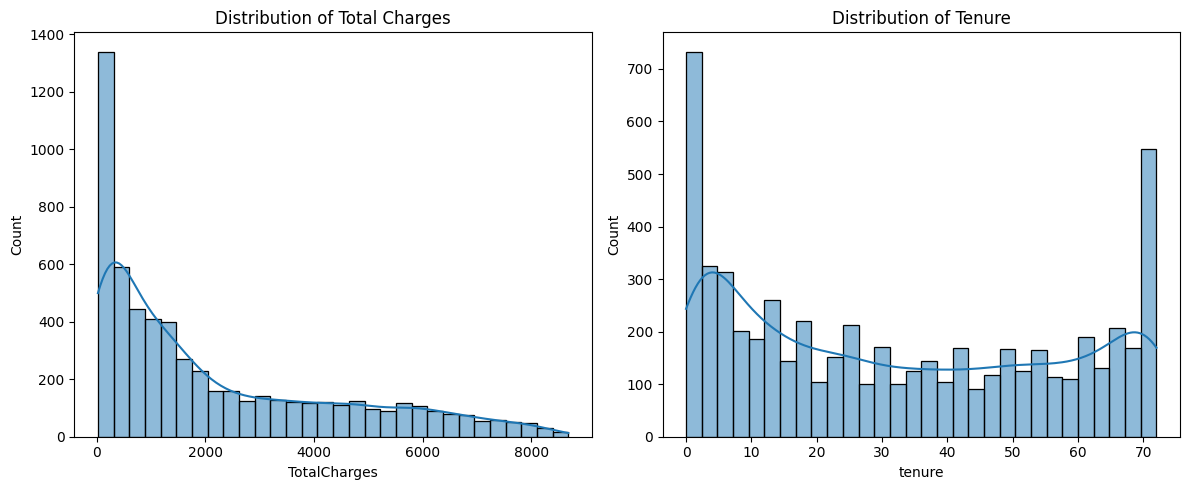

In [8]:
# Univariate Analysis
plt.figure(figsize=(12,5))

# Histogram for Total Charges
plt.subplot(1,2,1)
sns.histplot(df['TotalCharges'], bins=30, kde=True)
plt.title("Distribution of Total Charges")

# Histogram for Tenure
plt.subplot(1,2,2)
sns.histplot(df['tenure'], bins=30, kde=True)
plt.title("Distribution of Tenure")

plt.tight_layout()
plt.show()

# Interpretation of the distributions :

### Total Charges Distribution

- The distribution is highly right-skewed, indicating that most customers have low total charges, while a few -have significantly higher charges.
- The large spike at 0 suggests a considerable number of customers with either no or very minimal total charges, likely corresponding to new or short-term users.
- The presence of a long tail suggests that a smaller proportion of customers have very high total charges, possibly due to long tenure and higher monthly payments.

### Tenure Distribution
- The tenure distribution is bimodal, with peaks at 0 and around 70 months, suggesting many customers either recently joined or have been subscribed for a long time.
- The initial peak at 0 shows that a large proportion of customers are new.
- The relatively even distribution between 10 and 60 months suggests steady retention, while the rise around 70 months indicates long-term customers.

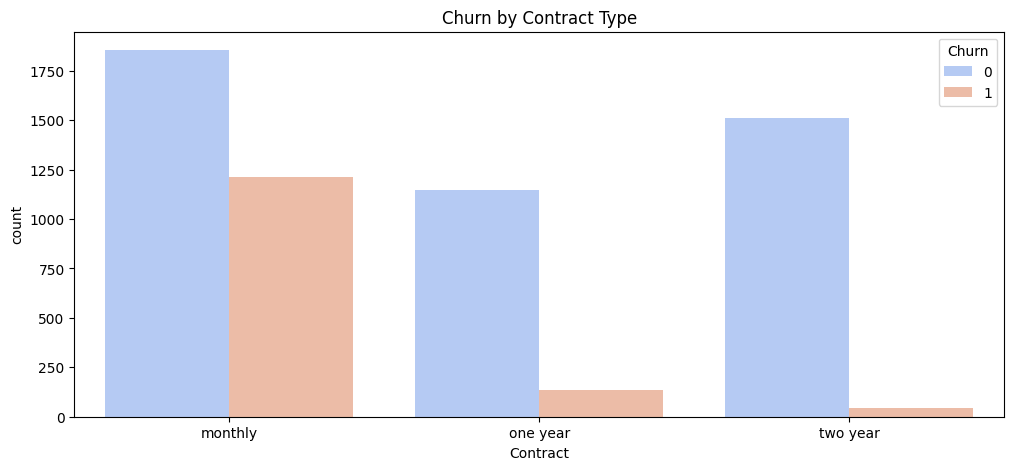

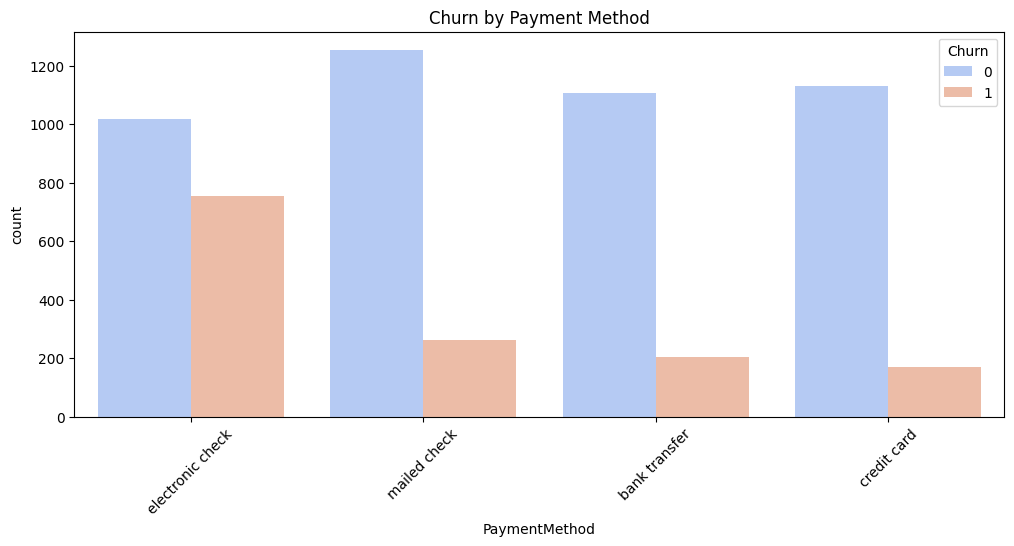

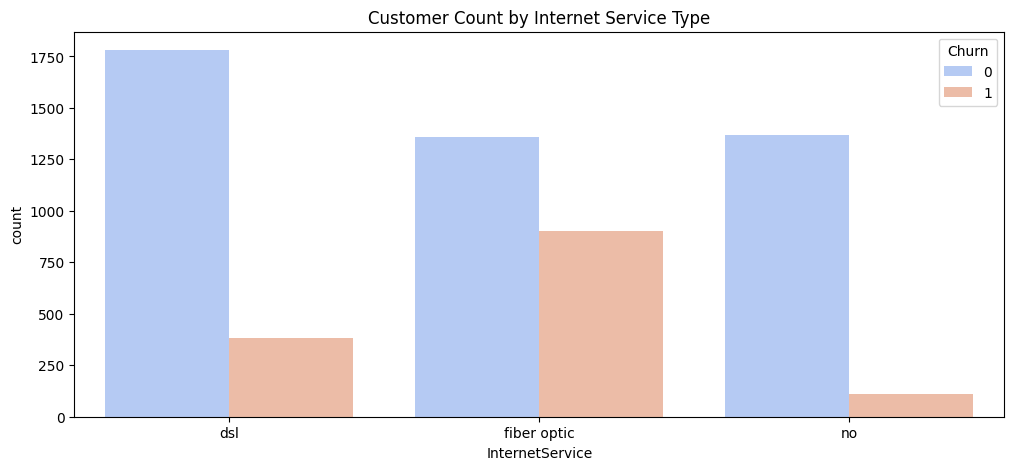

In [9]:
# Bar Plots
plt.figure(figsize=(12,5))
sns.countplot(x='Contract', hue='Churn', data=df, palette='coolwarm')
plt.title("Churn by Contract Type")
plt.show()

plt.figure(figsize=(12,5))
sns.countplot(x='PaymentMethod', hue='Churn', data=df, palette='coolwarm')
plt.title("Churn by Payment Method")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12,5))
sns.countplot(x='InternetService', hue='Churn', data=df, palette='coolwarm')
plt.title("Customer Count by Internet Service Type")
plt.show()

# Comments on Each Barplot
1. Customer Count by Internet Service Type
   - Observation: Customers with fiber optic service have the highest churn rate, while those with no internet service have the lowest churn.
   - Significance: Fiber optic users may be dissatisfied due to pricing or service quality. Customers without internet service tend to stay longer, possibly due to lower costs or fewer alternatives.
3. Churn by Contract Type
   - Observation: Monthly contract customers churn the most, while two-year contract customers churn the least.
   - Significance: Longer contracts provide stability and commitment, reducing churn, while monthly customers have the flexibility to leave anytime, leading to higher churn.
5. Churn by Payment Method
   - Observation: Customers using electronic checks have the highest churn, while mailed check, bank transfer, and credit card users have significantly lower churn.
   - Significance: Electronic check users might have less financial stability or prefer less secure payment methods, making them more likely to leave.

In [10]:
# Bivariate Analysis

# Ensure nbformat is installed
%pip install nbformat

# Scatter Plot: Tenure vs Monthly Charges
fig = px.scatter(df, x="tenure", y="MonthlyCharges", color='MonthlyCharges', size=df['MonthlyCharges']/2,
                 color_continuous_scale='viridis', title="Tenure vs. Monthly Charges")
fig.show()

# Box Plot: Contract Type vs Monthly Charges
fig = px.box(df, x='Contract', y='MonthlyCharges', color='Contract', title="Contract Type vs. Monthly Charges")
fig.show()

# Violin Plot: Payment Method vs Total Charges
fig = px.violin(df, x='PaymentMethod', y='TotalCharges', color='PaymentMethod', box=True,
                title="Payment Method vs. Total Charges")
fig.show()


Note: you may need to restart the kernel to use updated packages.


1. Contract Type vs. Monthly Charges
    - Observation: Monthly contract users have the highest range of charges, while one-year and two-year contracts show more uniform and lower median charges.
    - Significance: Monthly contract users might be paying premium rates, contributing to higher churn, while long-term contracts lock in stable pricing.
2. Payment Method vs. Total Charges
    - Observation: Customers using electronic checks show the highest variance in total charges, whereas other methods show more stability.
    - Significance: Higher variance suggests electronic check users might have unpredictable payments, leading to increased churn.

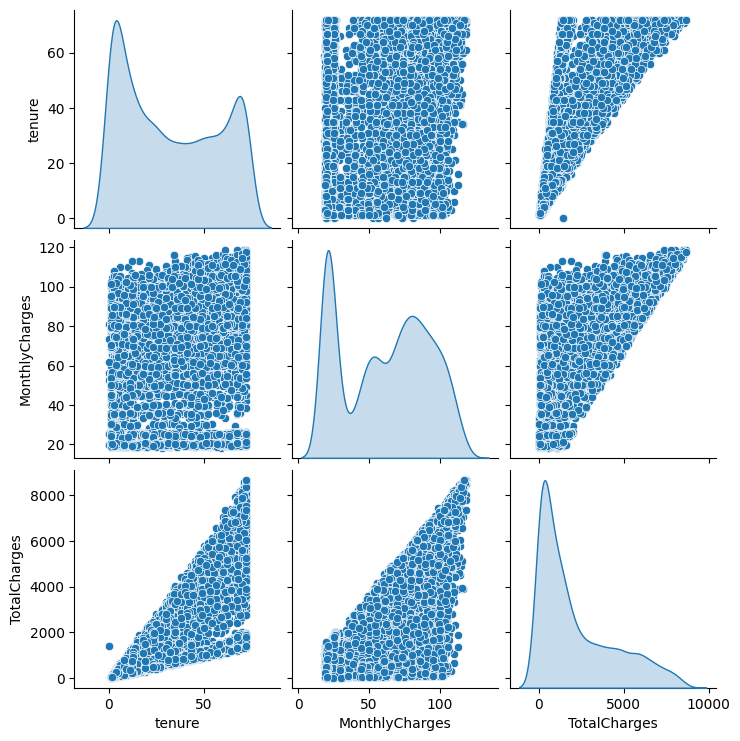

In [11]:
# Pair Plot: Key Numerical Features
sns.pairplot(df[['tenure', 'MonthlyCharges', 'TotalCharges']], diag_kind='kde')
plt.show()

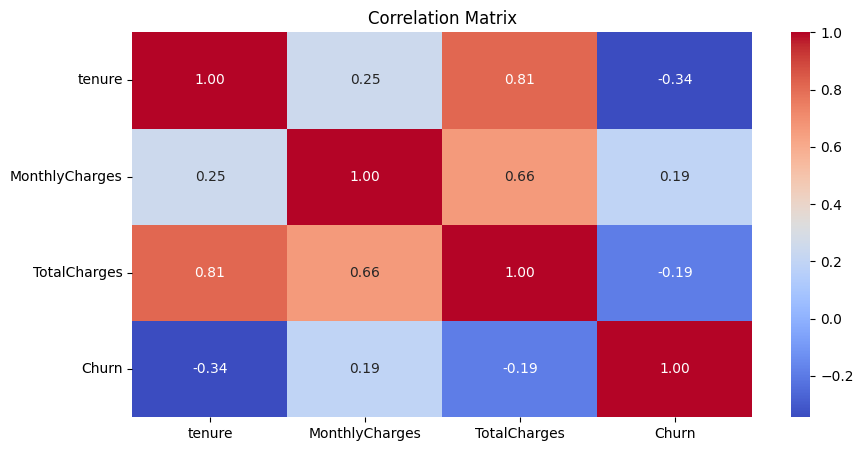

In [12]:
# Correlation Matrix (Relevant Numeric Data)
plt.figure(figsize=(10,5))
relevant_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']
sns.heatmap(df[relevant_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

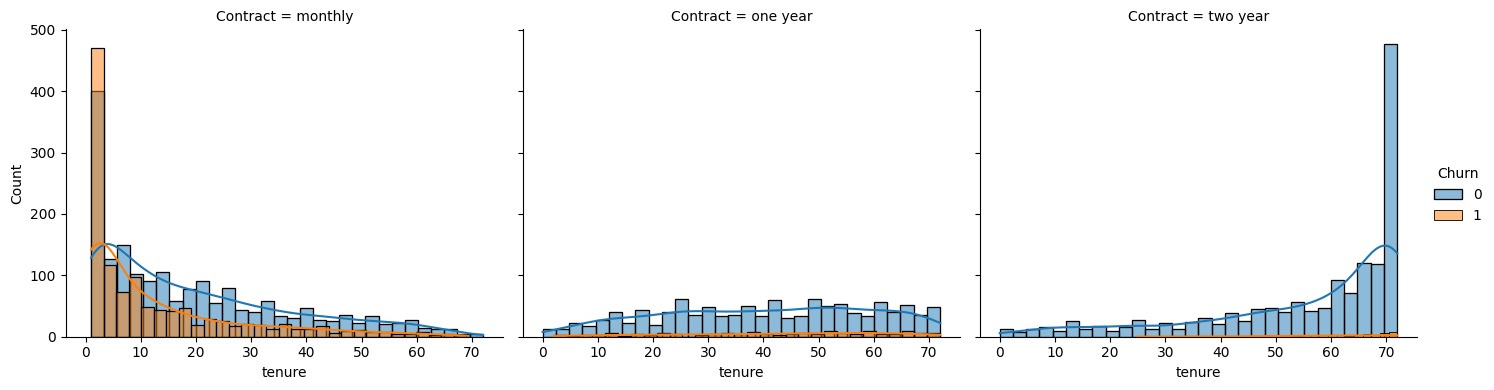

In [13]:
# Multivariate Analysis

# Facet Grid for Grouped Comparisons
facet = sns.FacetGrid(df, col='Contract', hue='Churn', height=4, aspect=1.2)
facet.map(sns.histplot, 'tenure', kde=True, bins=30).add_legend()
plt.show()

# Strategies

Based on the analysis and visualizations, here are some key strategies to reduce churn and improve customer retention:  

### **1. Address High Churn Among Monthly Contract Customers**  
- The first graph shows that churn is significantly higher for customers with **monthly contracts** compared to those with **one-year** or **two-year contracts**.  
- **Strategy**: Offer incentives such as discounts, loyalty rewards, or bundled services to encourage customers to switch from monthly to longer-term contracts.  

### **2. Improve Retention for Customers Using Electronic Check Payments**  
- The **Churn by Payment Method** graph indicates that customers using **electronic checks** have a higher churn rate compared to those using credit cards or bank transfers.  
- **Strategy**: Encourage customers to switch to more stable payment methods by offering benefits like cashback or reduced service fees for autopay using credit cards or direct bank transfers.  

### **3. Focus on Fiber Optic Internet Users**  
- The **Internet Service Type vs. Churn** graph shows that **fiber optic users** have a much higher churn rate than DSL or customers without internet service.  
- **Strategy**: Investigate complaints related to fiber optic service (e.g., speed, reliability, pricing) and implement service improvements, customer education, or loyalty programs to enhance customer experience.  

### **4. Target High-Monthly-Charge Customers with Loyalty Programs**  
- The **Tenure vs. Monthly Charges** scatter plot suggests that customers with **higher monthly charges** may be more likely to churn, especially those with shorter tenure.  
- **Strategy**: Implement tiered pricing, discounts for long-term customers, or exclusive benefits for high-paying customers to increase retention.  

### **5. Improve Customer Experience for Short-Tenure Customers**  
- The **Tenure vs. Monthly Charges** graph also suggests that newer customers may be more likely to leave early.  
- **Strategy**: Develop a strong **onboarding process**, provide proactive support, and send personalized engagement emails to help new customers see value in staying with the service.  

In [14]:
# Chi-Square Test: Contract vs Churn
contingency_table = pd.crosstab(df['Contract'], df['Churn'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print("Chi-Square Test Results:")
print(f"Chi2 Statistic: {chi2}, P-value: {p}")

Chi-Square Test Results:
Chi2 Statistic: 927.764842135184, P-value: 3.4548108784264303e-202


In [15]:
# ANOVA Test: Contract vs Monthly Charges
monthly = df[df['Contract'] == 'monthly']['MonthlyCharges']
one_year = df[df['Contract'] == 'one year']['MonthlyCharges']
two_year = df[df['Contract'] == 'two year']['MonthlyCharges']

anova_stat, anova_p = f_oneway(monthly, one_year, two_year)
print(f"ANOVA Test Statistic: {anova_stat}, P-value: {anova_p}")

# Interpretation of ANOVA Test
if anova_p < 0.05:
    print("There is a significant difference in Monthly Charges across different Contract types (p < 0.05).")
else:
    print("No significant difference in Monthly Charges across Contract types (p >= 0.05).")

ANOVA Test Statistic: 9.97662835529138, P-value: 4.726263273859407e-05
There is a significant difference in Monthly Charges across different Contract types (p < 0.05).


In [16]:
# T-Test: Churn vs Monthly Charges
yes_churn = df[df['Churn'] == 1]['MonthlyCharges']
no_churn = df[df['Churn'] == 0]['MonthlyCharges']

t_stat, t_p = ttest_ind(yes_churn, no_churn, equal_var=False)
print(f"T-Test Statistic: {t_stat}, P-value: {t_p}")

# Interpretation of T-Test
if t_p < 0.05:
    print("There is a significant difference in Monthly Charges between Churned and Non-Churned customers (p < 0.05).")
else:
    print("No significant difference in Monthly Charges between Churned and Non-Churned customers (p >= 0.05).")

T-Test Statistic: 16.61689230715437, P-value: 3.4539618387428994e-59
There is a significant difference in Monthly Charges between Churned and Non-Churned customers (p < 0.05).
